## Integration

Loading trained models...
Models loaded successfully
Tokenizer and metadata loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


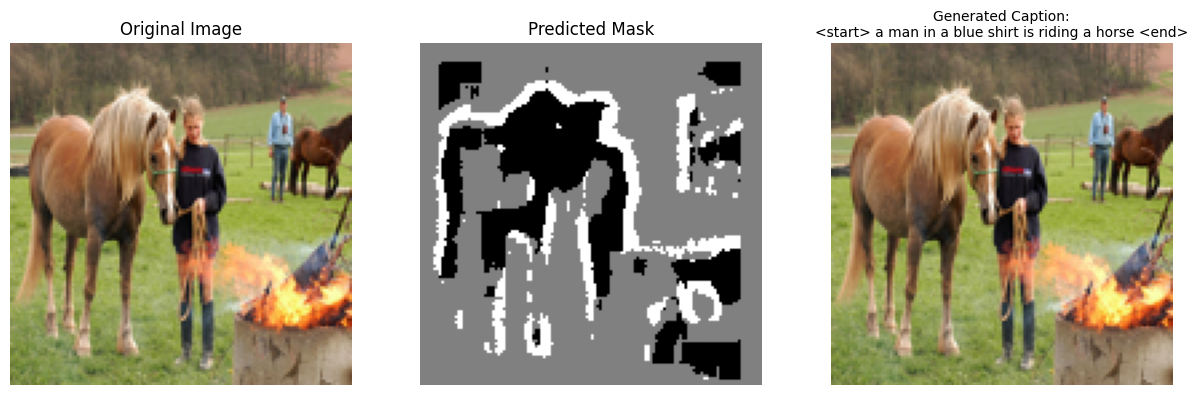

In [ ]:
# week9_integration.ipynb

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image

# Load Trained Models
print("Loading trained models...")
caption_model = load_model("./models/caption_model_final.keras", compile=False)
segmentation_model = load_model("./models/unet_model.h5", compile=False)

print("Models loaded successfully")

# Load Tokenizer + Metadata
import pickle, json

with open("./processed/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("./processed/metadata.json", "r") as f:
    metadata = json.load(f)

max_length = metadata["max_length"]
vocab_size = metadata["vocab_size"]

print("Tokenizer and metadata loaded.")

# Helper Functions
IMG_SIZE = 128

def preprocess_for_unet(image_path):
    """Prepare image for segmentation model"""
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img) / 255.0
    return np.expand_dims(arr, axis=0), img

def preprocess_for_captioning(image_path, feature_extractor):
    """Extract features for captioning model"""
    img = tf.keras.utils.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    features = feature_extractor.predict(img_array)
    return features

def create_mask(pred_mask):
    """Convert logits to predicted mask"""
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def generate_caption(model, tokenizer, photo, max_length):
    """Generate caption from extracted features"""
    in_text = "<start>"
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([photo, seq], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += " " + word
        if word == "<end>":
            break
    return in_text

# Load Feature Extractor (InceptionV3 for Captioning)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

base_model = InceptionV3(weights="imagenet")
feature_extractor = Model(base_model.input, base_model.layers[-2].output)

# Integration Pipeline
def run_pipeline(image_path):
    # Segmentation
    seg_input, original_img = preprocess_for_unet(image_path)
    pred_mask = segmentation_model.predict(seg_input)
    pred_mask = create_mask(pred_mask)

    # Captioning
    photo_features = preprocess_for_captioning(image_path, feature_extractor)
    caption = generate_caption(caption_model, tokenizer, photo_features, max_length)

    # Show results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title(f"Generated Caption:\n{caption}", fontsize=10, wrap=True)


    plt.show()

# Test the Integration
test_image = "./images/10815824_2997e03d76.jpg" # We can change to any test image
run_pipeline(test_image)
